In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import textstat
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import spacy 
from textstat import flesch_reading_ease
import re

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [5]:
news = pd.read_excel("Dataset/news_excerpts_parsed.xlsx")
news.head()

,Link,Text
0,https://edition.cnn.com/2023/09/29/business/st...,Starbucks violated federal labor law when it i...
1,https://www.channelnewsasia.com/singapore/su-w...,The first suspect to plead guilty in Singapore...
2,https://edition.cnn.com/2023/05/22/tech/meta-f...,Meta has been fined a record-breaking €1.2 bil...
3,https://www.channelnewsasia.com/singapore/bill...,SINGAPORE: A 45-year-old man linked to Singapo...
4,https://edition.cnn.com/2024/03/05/politics/li...,The Department of Education imposed a record $...


Text(0.5, 1.0, 'Number of characters')

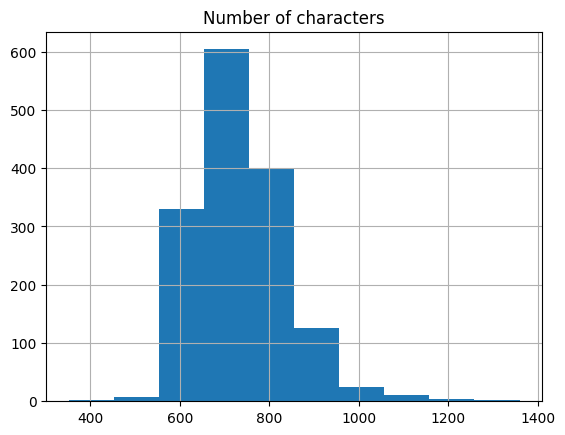

In [6]:
#Histogram of Characters 
news['Text'].str.len().hist()
plt.title("Number of characters")

In [7]:
def plot_word_nums_hist(text):
    text.str.split().map(lambda x: len(x)).hist()

Text(0.5, 1.0, 'Number of words')

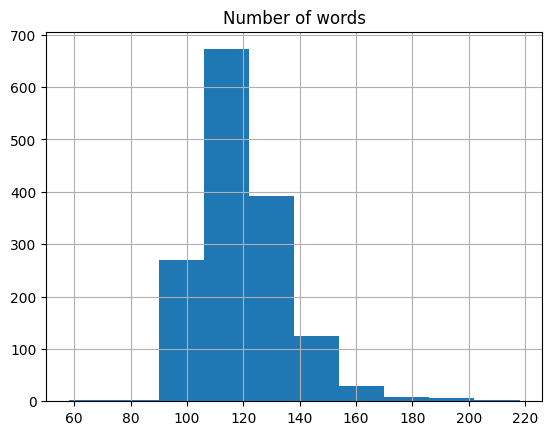

In [8]:
plot_word_nums_hist(news['Text'])
plt.title("Number of words")

In [9]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

Text(0.5, 1.0, 'Top Stopword Count')

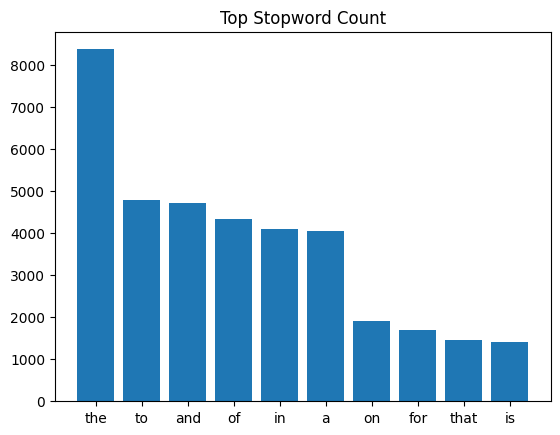

In [10]:
plot_top_stopwords_barchart(news['Text'])
plt.title('Top Stopword Count')

In [96]:
def plot_top_non_stopwords_barchart(text, exclude=None, top_n=10):
    if exclude is None:
        exclude = []
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter([word.strip('.,!?;"\'').lower() for word in corpus])
    most = counter.most_common()
    filtered_most = [(word, count) for word, count in most if word not in stop and word != '–' and word not in exclude and not word.isdigit()]
    
    x, y = zip(*filtered_most[:top_n])
    
    sns.barplot(x=y, y=x)
    plt.title(f'Top {top_n} Non-Stopword Count')

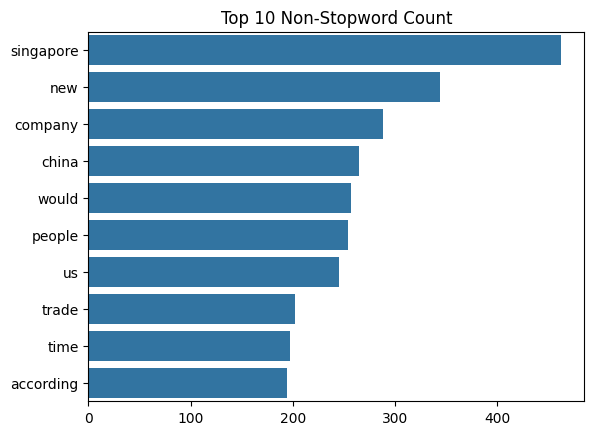

In [98]:
plot_top_non_stopwords_barchart(news['Text'],['said','also','two','one','year','years','last','first','mr','per','told'])

In [78]:
def plot_top_ngrams_barchart(text, n=2, exclude=None):
    if exclude is None:
        exclude = []
    stop = set(stopwords.words('english'))
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    new = text.str.split()
    new = new.values.tolist()
    corpus = [' '.join([word for word in i if word.lower() not in stop]) for i in new]
    tokens = [word for sentence in corpus for word in sentence.split()]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq

    top_n_bigrams = [item for item in _get_top_ngram(corpus, n) if item[0] not in exclude]
    top_n_bigrams = top_n_bigrams[:10]  # Get the next top 10 n-grams after excluding
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Top Bigram Count')

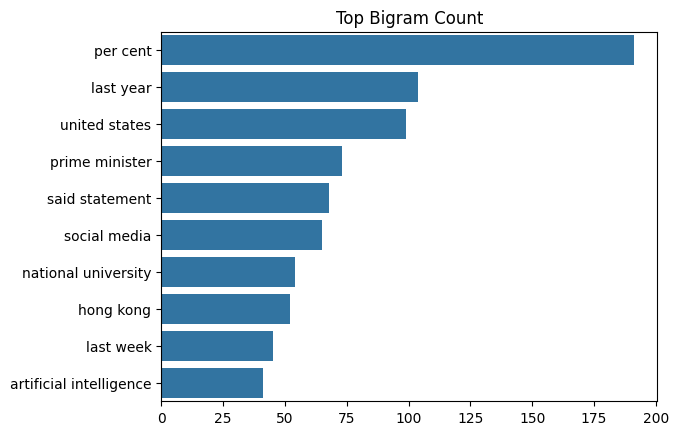

In [79]:
plot_top_ngrams_barchart(news['Text'],2)
plt.title("Top Bigram Count")

Text(0.5, 1.0, 'Top Trigram Count')

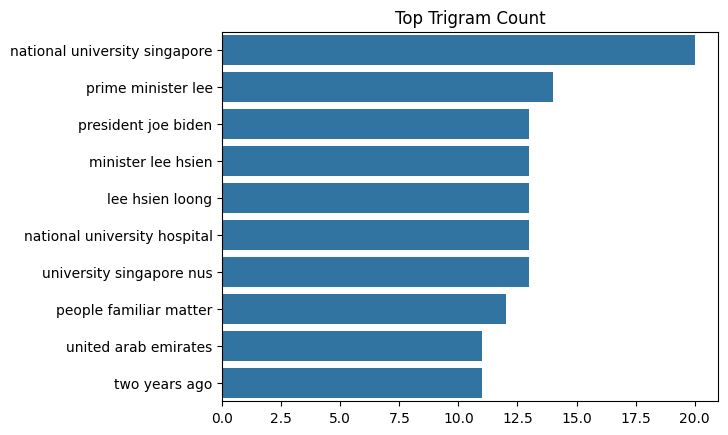

In [80]:
plot_top_ngrams_barchart(news['Text'],3)
plt.title("Top Trigram Count")

In [16]:
def preprocess_news(text):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in text:
        words = re.findall(r'\b\w+\b', news.lower())
        words = [lem.lemmatize(w) for w in words if len(w) > 2 and w not in stop]
        corpus.append(words)
    return corpus

In [17]:
def get_lda_objects(text):
    corpus=preprocess_news(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [18]:
lda_model, bow_corpus, dic = get_lda_objects(news['Text'])
lda_model.show_topics()

[(0,
  '0.013*"said" + 0.007*"year" + 0.004*"china" + 0.004*"company" + 0.004*"new" + 0.003*"state" + 0.003*"last" + 0.003*"two" + 0.003*"people" + 0.003*"country"'),
 (1,
  '0.011*"said" + 0.008*"year" + 0.005*"company" + 0.004*"singapore" + 0.004*"china" + 0.004*"also" + 0.004*"two" + 0.003*"trade" + 0.003*"new" + 0.003*"state"'),
 (2,
  '0.010*"said" + 0.007*"year" + 0.006*"singapore" + 0.004*"also" + 0.004*"company" + 0.003*"two" + 0.003*"country" + 0.003*"first" + 0.003*"time" + 0.003*"new"'),
 (3,
  '0.010*"said" + 0.007*"singapore" + 0.006*"year" + 0.005*"one" + 0.004*"time" + 0.003*"also" + 0.003*"national" + 0.003*"university" + 0.003*"two" + 0.003*"old"')]

In [19]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.082640 -0.035431       1        1  28.104073
1      0.018402  0.008244       2        1  27.517342
0      0.067134 -0.042853       3        1  23.912546
2     -0.002896  0.070041       4        1  20.466039, topic_info=           Term        Freq       Total Category  logprob  loglift
102   singapore  527.000000  527.000000  Default  30.0000  30.0000
305       china  305.000000  305.000000  Default  29.0000  29.0000
736       trade  178.000000  178.000000  Default  28.0000  28.0000
1253    patient   70.000000   70.000000  Default  27.0000  27.0000
2488       chip   43.000000   43.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
114    business   35.970785  143.807113   Topic4  -6.4104   0.2006
984   including   37.256462  166.526851   Topic4  -6.3753   0.0891
323   president   34.963429  146.608122   Topic4  -6.4388   0.1529
78         last   37.909607  248.113300   Topic4  -6.3579  -0.2923
277      people   36.556257  250.134456   Topic4  -6.3943  -0.3367

[375 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
5602       2  0.095081  acquisition
5602       3  0.855729  acquisition
5602       4  0.095081  acquisition
11305      4  0.794567    aesthetic
171        1  0.273371         also
...      ...       ...          ...
7005       2  0.893225         yang
200        1  0.230184         year
200        2  0.322258         year
200        3  0.241016         year
200        4  0.205812         year

[707 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [20]:
print(preprocess_news(news['Text'])[0])

['starbucks', 'violated', 'federal', 'labor', 'law', 'increased', 'wage', 'offered', 'new', 'perk', 'benefit', 'non', 'union', 'employee', 'national', 'labor', 'relation', 'board', 'judge', 'found', 'thursday', 'decision', 'latest', 'series', 'nlrb', 'ruling', 'finding', 'starbucks', 'violated', 'labor', 'law', 'effort', 'stop', 'union', 'forming', 'coffee', 'shop', 'issue', 'heart', 'case', 'whether', 'current', 'board', 'law', 'starbucks', 'entitled', 'explicitly', 'reward', 'employee', 'participating', 'union', 'activity', 'falsely', 'telling', 'worker', 'federal', 'labor', 'law', 'forced', 'take', 'action', 'wrote', 'administrative', 'law', 'judge', 'mara', 'louise', 'anzalone']


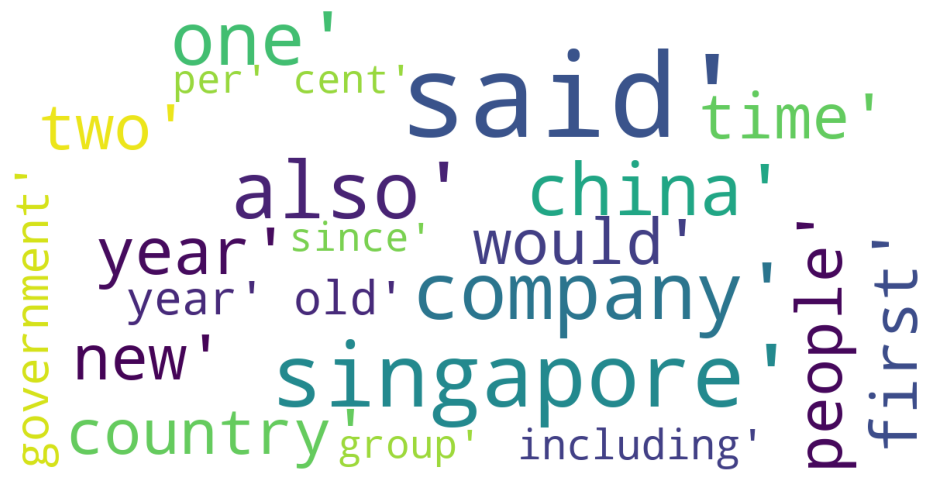

In [21]:
def plot_wordcloud(text):
    corpus = preprocess_news(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=20,
        max_font_size=50, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
plot_wordcloud(news['Text'])

<Axes: >

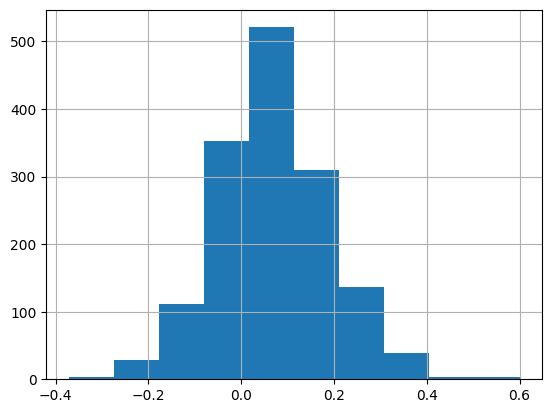

In [22]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score']=news['Text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

<BarContainer object of 3 artists>

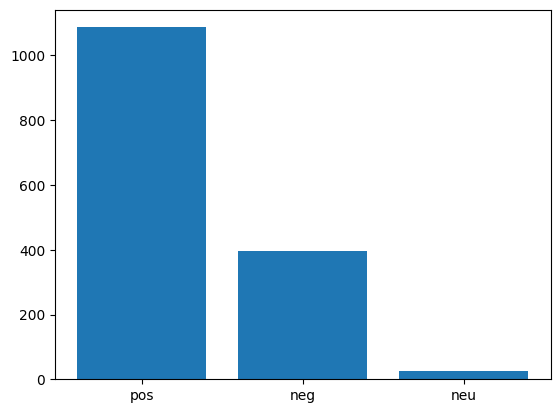

In [23]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'

news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))

plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

In [24]:
news[news['polarity']=='neg']['Text'].head()

3    SINGAPORE: A 45-year-old man linked to Singapo...
5    After twelve days of deliberation, a Vienna co...
6    China’s cyberspace regulator fined Didi Global...
7    On Thursday, the Brussels Criminal Court’s pro...
8    The Prague 3 District Court this morning sente...
Name: Text, dtype: object

In [25]:
news[news['polarity']=='pos']['Text'].head()

0    Starbucks violated federal labor law when it i...
1    The first suspect to plead guilty in Singapore...
2    Meta has been fined a record-breaking €1.2 bil...
4    The Department of Education imposed a record $...
9    Sanjay Shah, who was arrested in June 2022 in ...
Name: Text, dtype: object

In [26]:
nlp = spacy.load('en_core_web_sm')

In [27]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=news['Text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

In [99]:
spacy.displacy.render(nlp(news['Text'][0]),style='ent',jupyter=True)

/Users/danielwidjaja/github/datathon-2025/venv/lib/python3.11/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display


<Axes: >

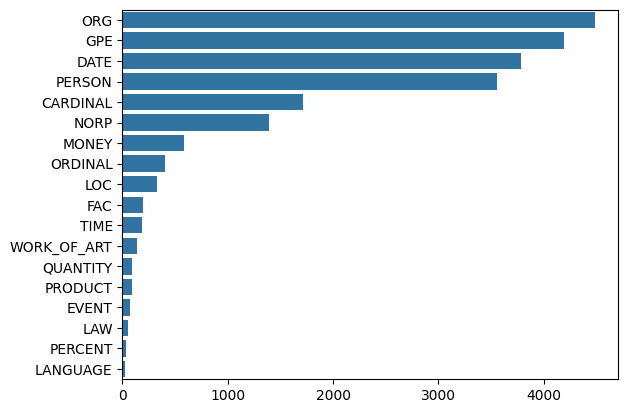

In [28]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)


In [64]:
def plot_most_common_named_entity_barchart(text, entity="PERSON", x_limits=0):
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent and len(X.text.split())>x_limits]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(x=y, y=x).set_title(entity)

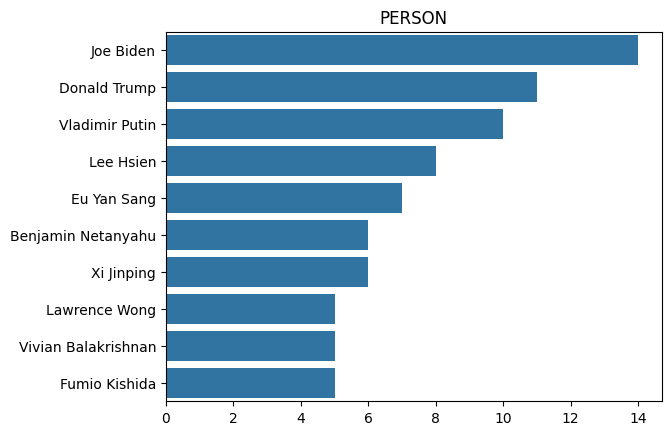

In [66]:
plot_most_common_named_entity_barchart(news['Text'], entity="PERSON",x_limits=1)

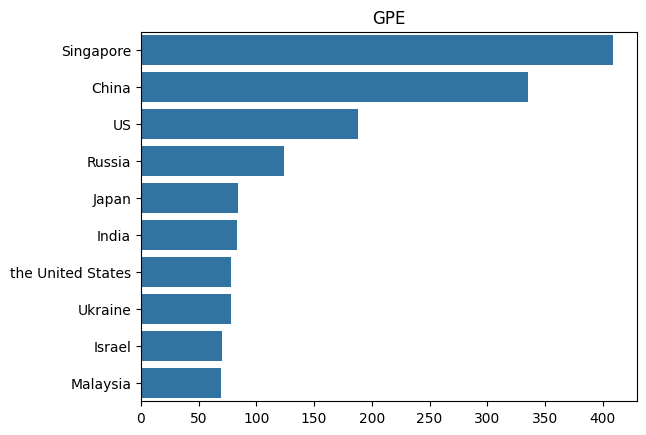

In [67]:
plot_most_common_named_entity_barchart(news['Text'], entity="GPE", x_limits=0)

In [32]:
def plot_parts_of_speach_barchart(text):

    def _get_pos(text):
        pos=nltk.pos_tag(word_tokenize(text))
        pos=list(map(list,zip(*pos)))[1]
        return pos
    
    tags=text.apply(lambda x : _get_pos(x))
    tags=[x for l in tags for x in l]
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(20))))
    
    sns.barplot(x=y,y=x)

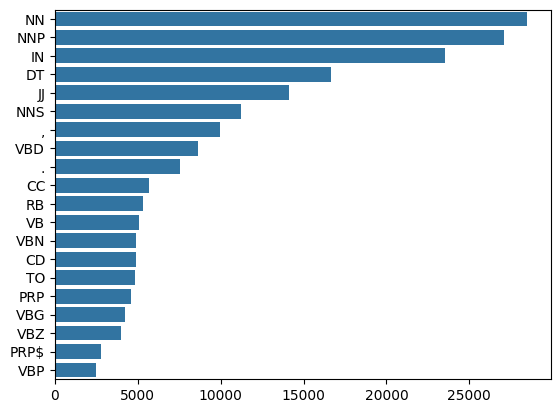

In [33]:
plot_parts_of_speach_barchart(news['Text'])

In [34]:
def plot_most_common_part_of_speach_barchart(text, part_of_speach='NN'):
    def _filter_pos(text):
        pos_type=[]
        pos=nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag==part_of_speach:
                pos_type.append(word)
        return pos_type
    words=text.apply(lambda x : _filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(20))))
    sns.barplot(x=y,y=x).set_title(part_of_speach)

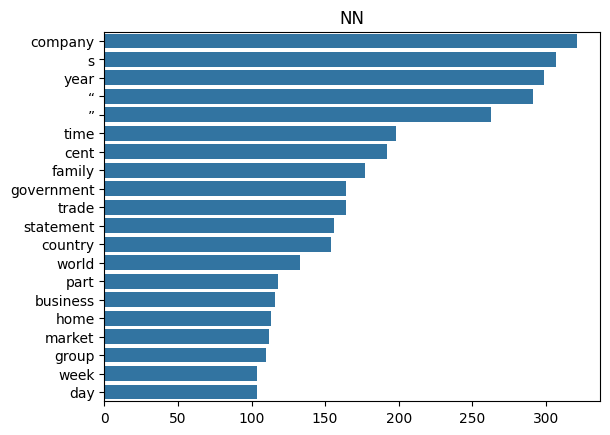

In [35]:
plot_most_common_part_of_speach_barchart(news['Text'])

In [36]:
def plot_text_complexity_histogram(text):
    text.apply(lambda x : flesch_reading_ease(x)).hist()

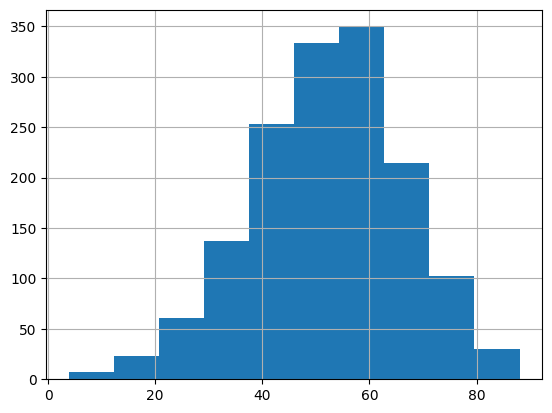

In [37]:
plot_text_complexity_histogram(news['Text'])